**Sources:**

[Orbit’s Documentation](https://orbit-ml.readthedocs.io/en/latest/tutorials/dlt.html#)
[GitHub Repository](https://github.com/uber/orbit)

---

# Import libraries

In [1]:
import pandas as pd
import numpy as np
from orbit.models import DLT
from orbit.diagnostics.plot import plot_predicted_data

# Load data

Data source: https://bdm.stat.gov.pl/

In [67]:
data = pd.read_csv('data/price_index_monthly.csv', sep=";")

data = (
    data
    .rename(columns={data.columns[0]: "index", data.columns[1]: "second_column", data.columns[2]: "unit"})
    .query('index == "Wskaźniki cen towarów i usług konsumpcyjnych"')
    .query('unit == "analogiczny okres roku poprzedniego=100"')
    .iloc[0]
    .reset_index()
    .rename(columns={"index": "date", 36: "price_index"})
    .query("date != 'index' and date != 'second_column' and date != 'unit'")
    .apply(lambda x: x.str.replace(',', '.') if x.name == 'price_index' else x)
    .astype({'date': str, 'price_index': float})
    .assign(price_index=lambda x: (x['price_index'] - 100))
    .assign(date=lambda x: np.where(x['date'].str.len() == 4, x['date'] + '.0', x['date']))
    .assign(year=lambda x: x['date'].str.split('.').str[0].astype(int))
    .assign(month=lambda x: x['date'].str.split('.').str[1].astype(int) + 1)
    .assign(date=lambda x: x['year'].astype(str) + "." + x['month'].astype(str))
    .drop(['year', 'month'], axis=1)
    .assign(date=lambda x: pd.to_datetime(x['date'], format='%Y.%m'))
    .append(pd.DataFrame({'date':pd.to_datetime("2023.05", format='%Y.%m'), 'price_index':13}, index=[0]))
    .set_index("date", drop=False)
    .sort_index()
)

data

/tmp/ipykernel_7377/998702423.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data


,date,price_index
date,,
2000-01-01,2000-01-01,10.1
2000-02-01,2000-02-01,10.4
2000-03-01,2000-03-01,10.3
2000-04-01,2000-04-01,9.8
2000-05-01,2000-05-01,10.0
...,...,...
2023-01-01,2023-01-01,16.6
2023-02-01,2023-02-01,18.4
2023-03-01,2023-03-01,16.1


<AxesSubplot:xlabel='date'>

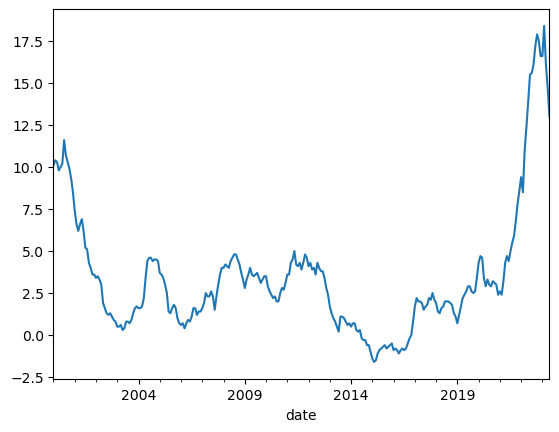

In [69]:
data.price_index.plot()

# Damped Local Trend Model

2023-06-19 00:29:26 - orbit - INFO - Sampling (PyStan) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 225 and samples(per chain): 25.


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

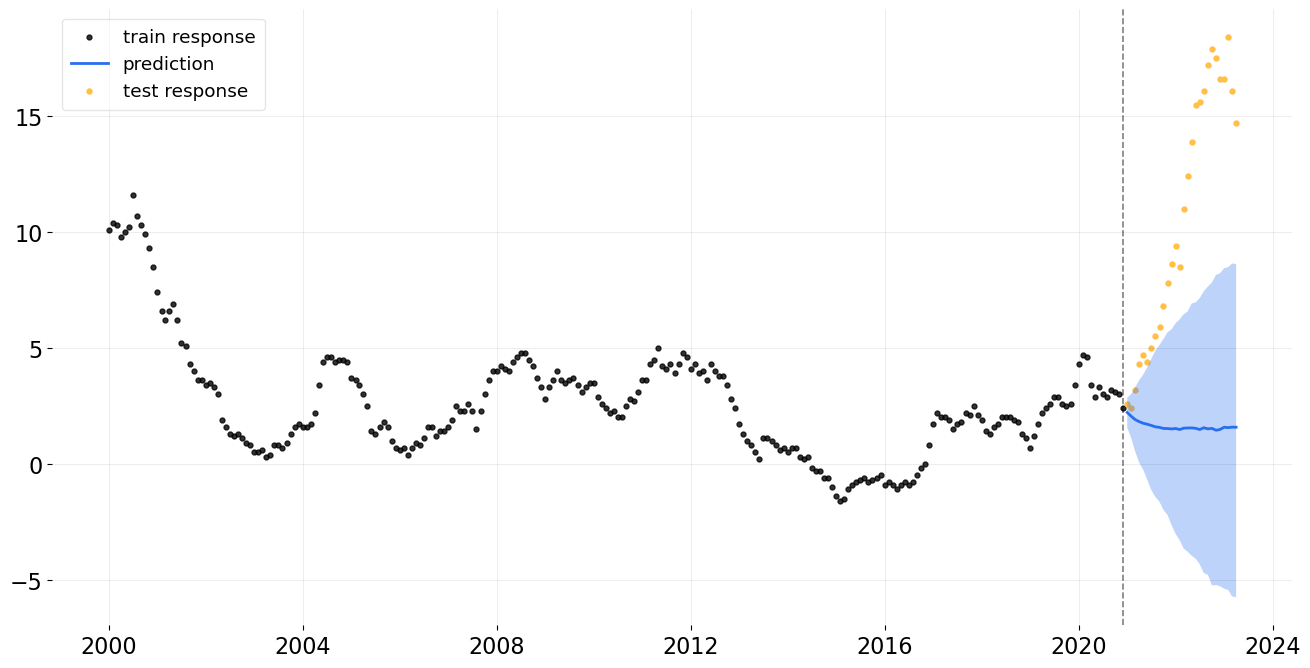

<AxesSubplot:>

In [65]:
train_period_dict = {"train_start":"2000-01-01", "train_end":"2020-12-01"}
test_period_dict = {"test_start":"2021-01-01", "test_end":"2023-04-01"}

train_df = data.loc[train_period_dict["train_start"]:train_period_dict["train_end"]]
test_df = data.loc[test_period_dict["test_start"]:test_period_dict["test_end"]]

dlt = DLT(
    response_col='price_index',
    date_col='date',
    estimator='stan-mcmc',
    #regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=0,
    global_trend_option='flat',
    n_bootstrap_draws=1000
)
dlt.fit(df=train_df)

# outcomes data frame
predicted_df = dlt.predict(df=test_df)

plot_predicted_data(
    training_actual_df=train_df, predicted_df=predicted_df,
    date_col=dlt.date_col, actual_col=dlt.response_col,
    test_actual_df=test_df
)